In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import os
import numpy as np
import joblib
from sklearn.metrics import auc, roc_curve
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt

# Import datasets

In [ ]:
csv_path = os.path.join("..", "..", "data", "LINKED_DATA", "TSR_ALL", "TSR_ALL31", "TSR_ALL31G_X_TRAIN.csv")
G_X_train = pd.read_csv(csv_path)

csv_path = os.path.join("..", "..", "data", "LINKED_DATA", "TSR_ALL", "TSR_ALL31", "TSR_ALL31G_y_TRAIN.csv")
G_y_train = pd.read_csv(csv_path)
G_y_train = np.ravel(G_y_train)

csv_path = os.path.join("..", "..", "data", "LINKED_DATA", "TSR_ALL", "TSR_ALL31", "TSR_ALL31G_X_TEST.csv")
G_X_test = pd.read_csv(csv_path)

csv_path = os.path.join("..", "..", "data", "LINKED_DATA", "TSR_ALL", "TSR_ALL31", "TSR_ALL31G_y_TEST.csv")
G_y_test = pd.read_csv(csv_path)
G_y_test = np.ravel(G_y_test)

In [2]:
csv_path = os.path.join("..", "..", "data", "LINKED_DATA", "TSR_ALL", "TSR_ALL31", "TSR_ALL31B_X_TRAIN.csv")
B_X_train = pd.read_csv(csv_path)

csv_path = os.path.join("..", "..", "data", "LINKED_DATA", "TSR_ALL", "TSR_ALL31", "TSR_ALL31B_y_TRAIN.csv")
B_y_train = pd.read_csv(csv_path)
B_y_train = np.ravel(B_y_train)

csv_path = os.path.join("..", "..", "data", "LINKED_DATA", "TSR_ALL", "TSR_ALL31", "TSR_ALL31B_X_TEST.csv")
B_X_test = pd.read_csv(csv_path)

csv_path = os.path.join("..", "..", "data", "LINKED_DATA", "TSR_ALL", "TSR_ALL31", "TSR_ALL31B_y_TEST.csv")
B_y_test = pd.read_csv(csv_path)
B_y_test = np.ravel(B_y_test)

(39881, 234)

# GOOD when Discharge

## Algorithms

## Extra trees

In [11]:
pkl_path = os.path.join("..", "..", "model", "model_pickle", "TSR_ALL31G_ET_BASED.pkl")
G_ET_BASED = joblib.load(pkl_path)

pkl_path = os.path.join("..", "..", "model", "model_pickle", "TSR_ALL31G_ET_TUNED.pkl")
G_ET_TUNED = joblib.load(pkl_path)

pkl_path = os.path.join("..", "..", "model", "model_pickle", "TSR_ALL31G_ET_CALIBRATED.pkl")
G_ET_CALIBRATED = joblib.load(pkl_path)

In [12]:
#BASED
G_y_test_pred = G_ET_BASED.predict_proba(G_X_test)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc)

#TUNED
print('--> Tuned Parameters Best Score: ', G_ET_TUNED.best_score_)
print('--> Best Parameters: \n', G_ET_TUNED.best_params_)

G_y_test_pred = G_ET_TUNED.predict_proba(G_X_test)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_tuned = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_tuned)

#CALIBRATED
G_y_test_pred = G_ET_CALIBRATED.predict_proba(G_X_test)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_cc = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_cc)

AUC of testing set: 0.8004578781605608
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--> Tuned Parameters Best Score:  0.837636929956145
--> Best Parameters: 
 {'extratreesclassifier__n_estimators': 100, 'extratreesclassifier__min_samples_split': 100, 'extratreesclassifier__max_samples': 0.3, 'extratreesclassifier__max_features': 0.9, 'extratreesclassifier__max_depth': 25, 'extratreesclassifier__criterion': 'entropy', 'extratreesclassifier__class_weight': 'balanced', 'extratreesclassifier__bootstrap': True}
AUC of testing set: 0.8345204717072615
AUC of testing set: 0.8373217078939712


### Selected Columns

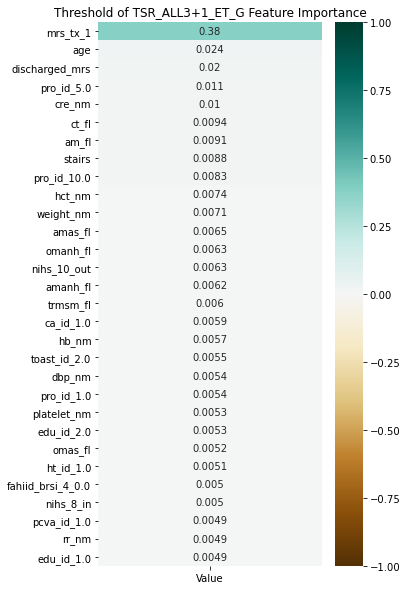

In [13]:
etG_fi = G_ET_CALIBRATED.base_estimator._final_estimator.feature_importances_
etG_fi_df = pd.DataFrame(etG_fi)
etG_fi_df.index = G_X_test.columns
etG_fi_df.columns = (["Value"])
etG_fi_df = etG_fi_df.reset_index(drop=False)
etG_fi_df.columns = (["Feature","Value"])
etG_fi_df = etG_fi_df.sort_values(["Value"], ascending=False)

In [15]:
G_test_auroc_list = []
G_test_auroc_tuned_list = []
G_test_auroc_cc_list = []

for i in 10,20,30:
    etG_fi_index = etG_fi_df[0:i].index
    
    G_X_train_selected = G_X_train.iloc[:, etG_fi_index]
    
    G_X_test_selected = G_X_test.iloc[:, etG_fi_index]
    
    # base et_selected
    et_selected = ExtraTreesClassifier(random_state=19)
    G_ET_BASED_selected = et_selected.fit(G_X_train_selected, G_y_train)
    
    G_y_test_pred = G_ET_BASED_selected.predict_proba(G_X_test_selected)
    fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
    G_test_auroc_selected = auc(fpr, tpr)
    G_test_auroc_list.append(G_test_auroc_selected)
    print('AUC of testing set:', G_test_auroc_selected)
    
    # tune et_selected   
    et_rscv_selected = G_ET_TUNED.best_estimator_
    G_ET_TUNED_selected = et_rscv_selected.fit(G_X_train_selected, G_y_train)

    G_y_test_pred = G_ET_TUNED_selected.predict_proba(G_X_test_selected)
    fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
    G_test_auroc_selected_tuned = auc(fpr, tpr)
    G_test_auroc_tuned_list.append(G_test_auroc_selected_tuned)
    print('AUC of testing set:', G_test_auroc_selected_tuned)

    # calibrate et_selected 
    et_cccv_selected = CalibratedClassifierCV(base_estimator=G_ET_TUNED_selected, cv=5)
    G_ET_CALIBRATED_selected = et_cccv_selected.fit(G_X_train_selected, G_y_train)

    G_y_test_pred = G_ET_CALIBRATED_selected.predict_proba(G_X_test_selected)
    fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
    G_test_auroc_selected_cc = auc(fpr, tpr)
    G_test_auroc_cc_list.append(G_test_auroc_selected_cc)
    print('AUC of testing set:', G_test_auroc_selected_cc)
    
G_test_auroc_list.append(G_test_auroc)
G_test_auroc_tuned_list.append(G_test_auroc_tuned)
G_test_auroc_cc_list.append(G_test_auroc_cc)

AUC of testing set: 0.784607114397865
AUC of testing set: 0.8375236633625798
AUC of testing set: 0.8370105531218773
AUC of testing set: 0.806976950092967
AUC of testing set: 0.8317242949477404
AUC of testing set: 0.8399635721242427
AUC of testing set: 0.8136170266589651
AUC of testing set: 0.8379672064794397
AUC of testing set: 0.8436409324524308


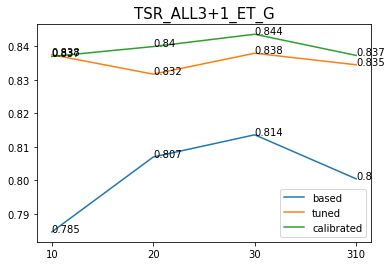

In [17]:
x = "10","20","30","311"
plt.plot(x, G_test_auroc_list, label = "based")
plt.plot(x, G_test_auroc_tuned_list, label = "tuned")
plt.plot(x, G_test_auroc_cc_list, label = "calibrated")
plt.legend()
for i in range(len(x)):
    plt.annotate(round(G_test_auroc_list[i],3), (x[i], G_test_auroc_list[i]))
    plt.annotate(round(G_test_auroc_tuned_list[i],3), (x[i], G_test_auroc_tuned_list[i]))
    plt.annotate(round(G_test_auroc_cc_list[i],3), (x[i], G_test_auroc_cc_list[i]))
plt.title('TSR_ALL31_ET_G', fontsize=15)
#plt.savefig('PLOT/TSR_ALL3/TSR_ALL31_ET_G.png')
plt.show()

## XGBClassifier

In [18]:
pkl_path = os.path.join("..", "..", "model", "model_pickle", "TSR_ALL31G_XGBC_BASED.pkl")
G_XGBC_BASED = joblib.load(pkl_path)

pkl_path = os.path.join("..", "..", "model", "model_pickle", "TSR_ALL31G_XGBC_TUNED.pkl")
G_XGBC_TUNED = joblib.load(pkl_path)

pkl_path = os.path.join("..", "..", "model", "model_pickle", "TSR_ALL31G_XGBC_CALIBRATED.pkl")
G_XGBC_CALIBRATED = joblib.load(pkl_path)

In [19]:
#BASED
G_y_test_pred = G_XGBC_BASED.predict_proba(G_X_test)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc)

#TUNED
print('--> Tuned Parameters Best Score: ', G_XGBC_TUNED.best_score_)
print('--> Best Parameters: \n', G_XGBC_TUNED.best_params_)

G_y_test_pred = G_XGBC_TUNED.predict_proba(G_X_test)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_tuned = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_tuned)

#CALIBRATED
G_y_test_pred = G_XGBC_CALIBRATED.predict_proba(G_X_test)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_cc = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_cc)

AUC of testing set: 0.8054266572786185
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--> Tuned Parameters Best Score:  0.8389884619341765
--> Best Parameters: 
 {'xgbclassifier__subsample': 0.3, 'xgbclassifier__scale_pos_weight': 0.04, 'xgbclassifier__reg_lambda': 0.1, 'xgbclassifier__reg_alpha': 10, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_depth': 25, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__colsample_bytree': 0.8}
AUC of testing set: 0.850800443543117
AUC of testing set: 0.8568413996062079


### Selected Columns

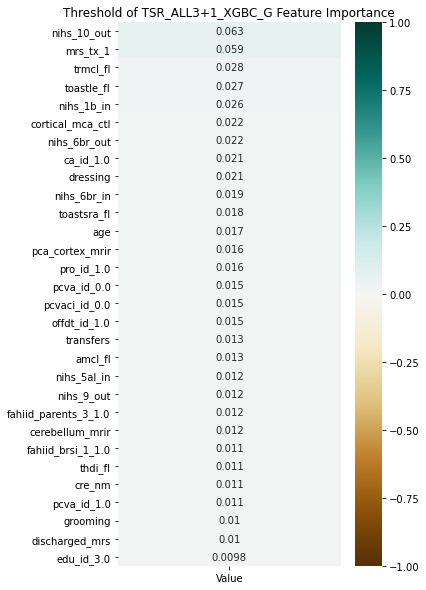

In [20]:
xgbcG_fi = G_XGBC_CALIBRATED.base_estimator._final_estimator.feature_importances_
xgbcG_fi_df = pd.DataFrame(xgbcG_fi)
xgbcG_fi_df.index = G_X_test.columns
xgbcG_fi_df.columns = (["Value"])
xgbcG_fi_df = xgbcG_fi_df.reset_index(drop=False)
xgbcG_fi_df.columns = (["Feature","Value"])
xgbcG_fi_df = xgbcG_fi_df.sort_values(["Value"], ascending=False)

In [22]:
G_test_auroc_list = []
G_test_auroc_tuned_list = []
G_test_auroc_cc_list = []

for i in 10,20,30:
    xgbcG_fi_index = xgbcG_fi_df[0:i].index
    
    G_X_train_selected = G_X_train.iloc[:, xgbcG_fi_index]
    
    G_X_test_selected = G_X_test.iloc[:, xgbcG_fi_index]
    
    # base xgbc_selected
    xgbc_selected = XGBClassifier(booster = "gbtree", random_state=19, use_label_encoder=False, eval_metric = "auc", tree_method = "hist", n_jobs=-1)
    G_XGBC_BASED_selected = xgbc_selected.fit(G_X_train_selected, G_y_train)
    
    G_y_test_pred = G_XGBC_BASED_selected.predict_proba(G_X_test_selected)
    fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
    G_test_auroc_selected = auc(fpr, tpr)
    G_test_auroc_list.append(G_test_auroc_selected)
    print('AUC of testing set:', G_test_auroc_selected)

    # tune xgbc_selected
    xgbcG_rscv_selected = G_XGBC_TUNED.best_estimator_
    G_XGBC_TUNED_selected = xgbcG_rscv_selected.fit(G_X_train_selected, G_y_train)

    G_y_test_pred = G_XGBC_TUNED_selected.predict_proba(G_X_test_selected)
    fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
    G_test_auroc_selected_tuned = auc(fpr, tpr)
    G_test_auroc_tuned_list.append(G_test_auroc_selected_tuned)
    print('AUC of testing set:', G_test_auroc_selected_tuned)

    # calibrate xgbc_selected
    xgbcG_cccv_selected = CalibratedClassifierCV(base_estimator=G_XGBC_TUNED_selected, cv=5)
    G_XGBC_CALIBRATED_selected = xgbcG_cccv_selected.fit(G_X_train_selected, G_y_train)

    G_y_test_pred = G_XGBC_CALIBRATED_selected.predict_proba(G_X_test_selected)
    fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
    G_test_auroc_selected_cc = auc(fpr, tpr)
    G_test_auroc_cc_list.append(G_test_auroc_selected_cc)
    print('AUC of testing set:', G_test_auroc_selected_cc)
    
G_test_auroc_list.append(G_test_auroc)
G_test_auroc_tuned_list.append(G_test_auroc_tuned)
G_test_auroc_cc_list.append(G_test_auroc_cc)

AUC of testing set: 0.78861038616078
AUC of testing set: 0.823087431118007
AUC of testing set: 0.824809744456765
AUC of testing set: 0.8124027641337205
AUC of testing set: 0.8450200479802346
AUC of testing set: 0.8458396751847745
AUC of testing set: 0.8143721461668514
AUC of testing set: 0.8530611642585199
AUC of testing set: 0.8514678663130689


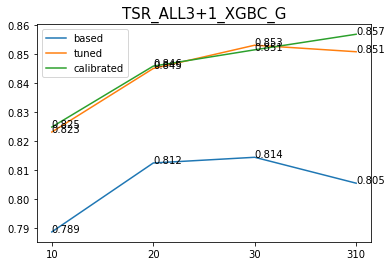

In [24]:
x = "10","20","30","311"
plt.plot(x, G_test_auroc_list, label = "based")
plt.plot(x, G_test_auroc_tuned_list, label = "tuned")
plt.plot(x, G_test_auroc_cc_list, label = "calibrated")
plt.legend()
for i in range(len(x)):
    plt.annotate(round(G_test_auroc_list[i],3), (x[i], G_test_auroc_list[i]))
    plt.annotate(round(G_test_auroc_tuned_list[i],3), (x[i], G_test_auroc_tuned_list[i]))
    plt.annotate(round(G_test_auroc_cc_list[i],3), (x[i], G_test_auroc_cc_list[i]))
plt.title('TSR_ALL31_XGBC_G', fontsize=15)
#plt.savefig('PLOT/TSR_ALL3/TSR_ALL31_XGBC_G.png')
plt.show()

# BAD when Discharge

## Algorithms

## Extra trees

In [31]:
pkl_path = os.path.join("..", "..", "model", "model_pickle", "TSR_ALL31B_ET_BASED.pkl")
B_ET_BASED = joblib.load(pkl_path)

pkl_path = os.path.join("..", "..", "model", "model_pickle", "TSR_ALL31B_ET_TUNED.pkl")
B_ET_TUNED = joblib.load(pkl_path)

pkl_path = os.path.join("..", "..", "model", "model_pickle", "TSR_ALL31B_ET_CALIBRATED.pkl")
B_ET_CALIBRATED = joblib.load(pkl_path)

In [32]:
### BASED ET
B_y_test_pred = B_ET_BASED.predict_proba(B_X_test)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc)

### TUNED ET
print('--> Tuned Parameters Best Score: ', B_ET_TUNED.best_score_)
print('--> Best Parameters: \n', B_ET_TUNED.best_params_)

B_y_test_pred = B_ET_TUNED.predict_proba(B_X_test)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_tuned = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_tuned)

### CALIBRATED ET
B_y_test_pred = B_ET_CALIBRATED.predict_proba(B_X_test)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_cc = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_cc)

AUC of testing set: 0.903825083775221
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--> Tuned Parameters Best Score:  0.9290657121145953
--> Best Parameters: 
 {'extratreesclassifier__n_estimators': 100, 'extratreesclassifier__min_samples_split': 100, 'extratreesclassifier__max_samples': 0.3, 'extratreesclassifier__max_features': 0.9, 'extratreesclassifier__max_depth': 25, 'extratreesclassifier__criterion': 'entropy', 'extratreesclassifier__class_weight': 'balanced', 'extratreesclassifier__bootstrap': True}
AUC of testing set: 0.925305863604573
AUC of testing set: 0.9259577040733349


### Selected Columns

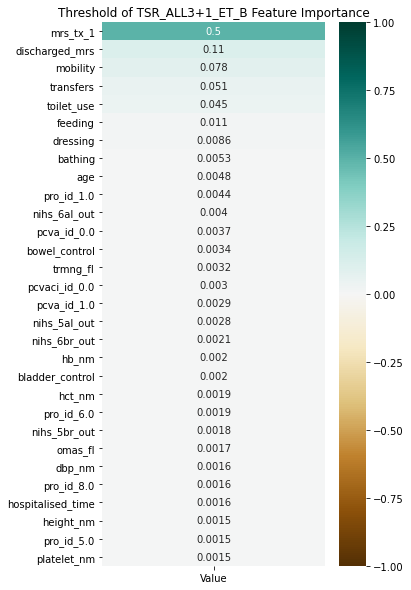

In [33]:
etB_fi = B_ET_CALIBRATED.base_estimator._final_estimator.feature_importances_
etB_fi_df = pd.DataFrame(etB_fi)
etB_fi_df.index = B_X_test.columns
etB_fi_df.columns = (["Value"])
etB_fi_df = etB_fi_df.reset_index(drop=False)
etB_fi_df.columns = (["Feature","Value"])
etB_fi_df = etB_fi_df.sort_values(["Value"], ascending=False)

In [35]:
B_test_auroc_list = []
B_test_auroc_tuned_list = []
B_test_auroc_cc_list = []

for i in 10,20,30:
    etB_fi_index = etB_fi_df[0:i].index
    
    B_X_train_selected = B_X_train.iloc[:, etB_fi_index]
    
    B_X_test_selected = B_X_test.iloc[:, etB_fi_index]
    
    # base et_selected
    et_selected = ExtraTreesClassifier(random_state=19)
    B_ET_BASED_selected = et_selected.fit(B_X_train_selected, B_y_train)
    
    B_y_test_pred = B_ET_BASED_selected.predict_proba(B_X_test_selected)
    fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
    B_test_auroc_selected = auc(fpr, tpr)
    B_test_auroc_list.append(B_test_auroc_selected)
    print('AUC of testing set:', B_test_auroc_selected)
    
    # tune et_selected   
    et_rscv_selected = B_ET_TUNED.best_estimator_
    B_ET_TUNED_selected = et_rscv_selected.fit(B_X_train_selected, B_y_train)

    B_y_test_pred = B_ET_TUNED_selected.predict_proba(B_X_test_selected)
    fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
    B_test_auroc_selected_tuned = auc(fpr, tpr)
    B_test_auroc_tuned_list.append(B_test_auroc_selected_tuned)
    print('AUC of testing set:', B_test_auroc_selected_tuned)

    # calibrate et_selected 
    et_cccv_selected = CalibratedClassifierCV(base_estimator=B_ET_TUNED_selected, cv=5)
    B_ET_CALIBRATED_selected = et_cccv_selected.fit(B_X_train_selected, B_y_train)

    B_y_test_pred = B_ET_CALIBRATED_selected.predict_proba(B_X_test_selected)
    fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
    B_test_auroc_selected_cc = auc(fpr, tpr)
    B_test_auroc_cc_list.append(B_test_auroc_selected_cc)
    print('AUC of testing set:', B_test_auroc_selected_cc)
    
B_test_auroc_list.append(B_test_auroc)
B_test_auroc_tuned_list.append(B_test_auroc_tuned)
B_test_auroc_cc_list.append(B_test_auroc_cc)

AUC of testing set: 0.8447485392854207
AUC of testing set: 0.919883605457932
AUC of testing set: 0.9198835336218653
AUC of testing set: 0.9041838330920597
AUC of testing set: 0.9234869743970511
AUC of testing set: 0.923701979744528
AUC of testing set: 0.9163440987820626
AUC of testing set: 0.9241036151931559
AUC of testing set: 0.9242174035227259


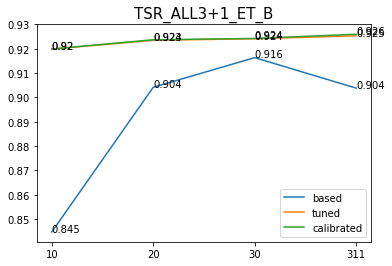

In [37]:
x = "10","20","30","311"
plt.plot(x, B_test_auroc_list, label = "based")
plt.plot(x, B_test_auroc_tuned_list, label = "tuned")
plt.plot(x, B_test_auroc_cc_list, label = "calibrated")
plt.legend()
for i in range(len(x)):
    plt.annotate(round(B_test_auroc_list[i],3), (x[i], B_test_auroc_list[i]))
    plt.annotate(round(B_test_auroc_tuned_list[i],3), (x[i], B_test_auroc_tuned_list[i]))
    plt.annotate(round(B_test_auroc_cc_list[i],3), (x[i], B_test_auroc_cc_list[i]))
plt.title('TSR_ALL31_ET_B', fontsize=15)
#plt.savefig('PLOT/TSR_ALL3/TSR_ALL31_ET_B.png')
plt.show()

## XGBClassifier

In [38]:
pkl_path = os.path.join("..", "..", "model", "model_pickle", "TSR_ALL31B_XGBC_BASED.pkl")
B_XGBC_BASED = joblib.load(pkl_path)

pkl_path = os.path.join("..", "..", "model", "model_pickle", "TSR_ALL31B_XGBC_TUNED.pkl")
B_XGBC_TUNED = joblib.load(pkl_path)

pkl_path = os.path.join("..", "..", "model", "model_pickle", "TSR_ALL31B_XGBC_CALIBRATED.pkl")
B_XGBC_CALIBRATED = joblib.load(pkl_path)

In [39]:
### BASED XGBC
B_y_test_pred = B_XGBC_BASED.predict_proba(B_X_test)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc)

### TUNED XGBC
print("--> Tuned Parameters Best Score: ", B_XGBC_TUNED.best_score_)
print("--> Best Parameters: \n", B_XGBC_TUNED.best_params_)

B_y_test_pred = B_XGBC_TUNED.predict_proba(B_X_test)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_tuned = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_tuned)

### CALIBRATED XGBC
B_y_test_pred = B_XGBC_CALIBRATED.predict_proba(B_X_test)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_cc = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_cc)

AUC of training set: 0.9999047592542774
AUC of testing set: 0.9203901933999321
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--> Tuned Parameters Best Score:  0.9311077548366142
--> Best Parameters: 
 {'xgbclassifier__subsample': 0.8, 'xgbclassifier__scale_pos_weight': 3, 'xgbclassifier__reg_lambda': 10, 'xgbclassifier__reg_alpha': 10, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_depth': 25, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 10, 'xgbclassifier__colsample_bytree': 0.8}
AUC of training set: 0.9525685882827082
AUC of testing set: 0.9282495619436655
AUC of training set: 0.9497560357791858
AUC of testing set: 0.9285271365051926


### Selected Columns

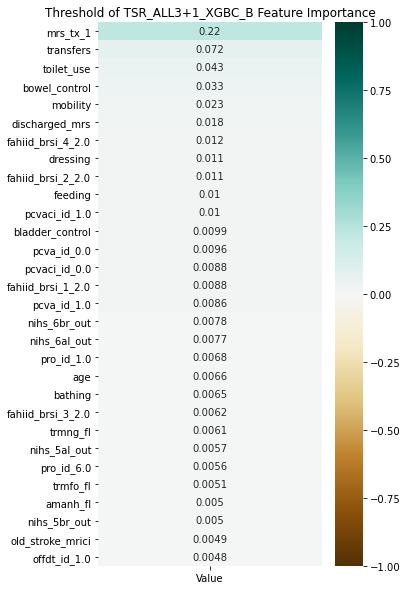

In [40]:
xgbcB_fi = B_XGBC_CALIBRATED.base_estimator._final_estimator.feature_importances_
xgbcB_fi_df = pd.DataFrame(xgbcB_fi)
xgbcB_fi_df.index = B_X_test.columns
xgbcB_fi_df.columns = (["Value"])
xgbcB_fi_df = xgbcB_fi_df.reset_index(drop=False)
xgbcB_fi_df.columns = (["Feature","Value"])
xgbcB_fi_df = xgbcB_fi_df.sort_values(["Value"], ascending=False)

In [42]:
B_test_auroc_list = []
B_test_auroc_tuned_list = []
B_test_auroc_cc_list = []

for i in 10,20,30:
    xgbcB_fi_index = xgbcB_fi_df[0:i].index
    
    B_X_train_selected = B_X_train.iloc[:, xgbcB_fi_index]
    
    B_X_test_selected = B_X_test.iloc[:, xgbcB_fi_index]
    
    # base xgbc_selected
    xgbc_selected = XGBClassifier(booster = "gbtree", random_state=19, use_label_encoder=False, eval_metric = "auc", tree_method = "hist", n_jobs=-1)
    B_XGBC_BASED_selected = xgbc_selected.fit(B_X_train_selected, B_y_train)
    
    B_y_test_pred = B_XGBC_BASED_selected.predict_proba(B_X_test_selected)
    fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
    B_test_auroc_selected = auc(fpr, tpr)
    B_test_auroc_list.append(B_test_auroc_selected)
    print('AUC of testing set:', B_test_auroc_selected)

    # tune xgbc_selected
    xgbcB_rscv_selected = B_XGBC_TUNED.best_estimator_
    B_XGBC_TUNED_selected = xgbcB_rscv_selected.fit(B_X_train_selected, B_y_train)

    B_y_test_pred = B_XGBC_TUNED_selected.predict_proba(B_X_test_selected)
    fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
    B_test_auroc_selected_tuned = auc(fpr, tpr)
    B_test_auroc_tuned_list.append(B_test_auroc_selected_tuned)
    print('AUC of testing set:', B_test_auroc_selected_tuned)

    # calibrate xgbc_selected
    xgbcB_cccv_selected = CalibratedClassifierCV(base_estimator=B_XGBC_TUNED_selected, cv=5)
    B_XGBC_CALIBRATED_selected = xgbcB_cccv_selected.fit(B_X_train_selected, B_y_train)

    B_y_test_pred = B_XGBC_CALIBRATED_selected.predict_proba(B_X_test_selected)
    fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
    B_test_auroc_selected_cc = auc(fpr, tpr)
    B_test_auroc_cc_list.append(B_test_auroc_selected_cc)
    print('AUC of testing set:', B_test_auroc_selected_cc)
    
B_test_auroc_list.append(B_test_auroc)
B_test_auroc_tuned_list.append(B_test_auroc_tuned)
B_test_auroc_cc_list.append(B_test_auroc_cc)

AUC of testing set: 0.9174687642415001
AUC of testing set: 0.9213459004306142
AUC of testing set: 0.9211609225589961
AUC of testing set: 0.9175345660785496
AUC of testing set: 0.9261073386001623
AUC of testing set: 0.9260983590918311
AUC of testing set: 0.9192584161698962
AUC of testing set: 0.9267716785445208
AUC of testing set: 0.9265681669677076


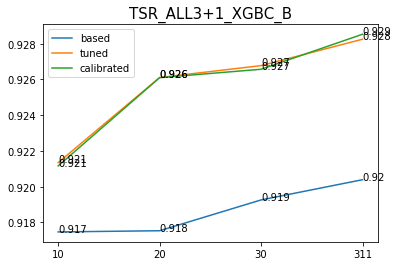

In [44]:
x = "10","20","30","311"
plt.plot(x, B_test_auroc_list, label = "based")
plt.plot(x, B_test_auroc_tuned_list, label = "tuned")
plt.plot(x, B_test_auroc_cc_list, label = "calibrated")
plt.legend()
for i in range(len(x)):
    plt.annotate(round(B_test_auroc_list[i],3), (x[i], B_test_auroc_list[i]))
    plt.annotate(round(B_test_auroc_tuned_list[i],3), (x[i], B_test_auroc_tuned_list[i]))
    plt.annotate(round(B_test_auroc_cc_list[i],3), (x[i], B_test_auroc_cc_list[i]))
plt.title('TSR_ALL31_XGBC_B', fontsize=15)
#plt.savefig('PLOT/TSR_ALL3/TSR_ALL31_XGBC_B.png')
plt.show()